The purpose of this model
is to validate the end-to-end pipeline and provide a performance reference point
before applying more advanced models and optimization techniques.

In [4]:
import pandas as pd
import numpy as np

# 1. Load the REAL data you engineered
# (This file was created in your feature_engineering.ipynb)
try:
    # Attempt to load from the location used in other cells if current dir fails
    try:
        df = pd.read_parquet("engineered_data_sample.parquet")
    except FileNotFoundError:
        df = pd.read_parquet("/tmp/aai540/engineered_data_sample.parquet")
        
    print("✅ Loaded Real Backblaze Data!")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("❌ Error: Could not find 'engineered_data_sample.parquet'")
    print("👉 Go back to feature_engineering.ipynb and run the last cell!")
    # Stop execution if data is missing, otherwise subsequent lines fail with NameError
    raise

# 2. Select Features & Target
# We use the Rolling Features we created
features = ['smart_5_raw_roll7', 'smart_187_raw_roll7', 'smart_197_raw_roll7', 'smart_198_raw_roll7']
target = 'failure'

# Check if columns exist before dropping to avoid KeyError
missing_features = [f for f in features if f not in df.columns]

if missing_features:
    print("⚠️ Warning: Rolling features specified in list not found in dataframe. Falling back to raw features.")
    # Fallback to raw features since rolling ones are missing
    features = ['smart_5_raw', 'smart_187_raw', 'smart_197_raw', 'smart_198_raw']
    # Only keep the ones that actually exist
    features = [f for f in features if f in df.columns]
    
    if not features:
        raise ValueError("No suitable features (rolling or raw) found in the dataframe!")

# Drop rows where selected features are NaN
df_clean = df.dropna(subset=features)

X = df_clean[features]
y = df_clean[target]
y = df_clean[target]

print(f"Features ready: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

✅ Loaded Real Backblaze Data!
Shape: (271976, 193)
⚠️ Warning: Rolling features specified in list not found in dataframe. Falling back to raw features.
Features ready: (109517, 4)
Target distribution:
failure
0    109513
1         4
Name: count, dtype: int64


In [5]:
import pandas as pd
from pathlib import Path

engineered_path = Path("/tmp/aai540/engineered_data_sample.parquet")

assert engineered_path.exists(), "Engineered file not found!"

df = pd.read_parquet(engineered_path)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (271976, 193)


,date,serial_number,model,capacity_bytes,failure,datacenter,cluster_id,vault_id,pod_id,pod_slot_num,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2024-01-13,WD-WX31DB48X22V,WDC WD60EFRX,6001175126016,0,sac0,0,1002,0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-13,Z4D00WGP,ST6000DX000,6001175126016,0,sac0,0,1002,0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-13,Z4D00YC6,ST6000DX000,6001175126016,0,sac0,0,1002,0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-13,Z4D00YS2,ST6000DX000,6001175126016,0,sac0,0,1002,0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-13,Z4D029JS,ST6000DX000,6001175126016,0,sac0,0,1002,0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
%pip install seaborn

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Load Engineered Feature Dataset

The dataset used here is the output of the feature engineering step, containing
numerical features and encoded categorical variables suitable for modeling.


### Define Features and Target Variable

The target variable represents the prediction objective, while all remaining
columns are treated as input features.


In [7]:
TARGET_COLUMN = "label"
if TARGET_COLUMN not in df.columns:
    TARGET_COLUMN = "failure"

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

X.shape, y.shape

((271976, 192), (271976,))

### Train-Test Split

The dataset is split into training and testing subsets to evaluate model
generalization performance.


In [8]:
from sklearn.model_selection import train_test_split

# Drop non-numeric columns for the model
X_numeric = X.drop(columns=['date', 'serial_number', 'model'], errors='ignore')

# Only stratify if each class has at least 2 samples
class_counts = y.value_counts()
use_stratify = class_counts.min() >= 2
stratify_arg = y if use_stratify else None

X_train, X_test, y_train, y_test = train_test_split(
    X_numeric,
    y,
    test_size=0.2,
    random_state=42,
    stratify=stratify_arg
 )

### Baseline Model: Logistic Regression

Logistic Regression is used as a simple and interpretable baseline model to
validate the pipeline before exploring more complex algorithms.


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path

# Ensure X and y exist (fallback load if needed)
if 'X' not in globals() or 'y' not in globals():
    engineered_path = Path("/tmp/aai540/engineered_data_sample.parquet")
    if engineered_path.exists():
        df = pd.read_parquet(engineered_path)
    else:
        df = pd.read_parquet("engineered_data_sample.parquet")
    target_col = "label" if "label" in df.columns else "failure"
    X = df.drop(columns=[target_col])
    y = df[target_col]

# Rebuild numeric-only features to avoid string conversion errors
X_numeric = X.select_dtypes(include=["number"]).copy()
if X_numeric.empty:
    raise ValueError("No numeric features available for training.")

# Drop columns that are entirely NaN, then fill remaining NaNs
X_numeric = X_numeric.dropna(axis=1, how="all").fillna(0)
if X_numeric.empty or len(X_numeric) == 0:
    raise ValueError("No usable numeric data after cleaning. Check engineered features output.")

y_filtered = y.loc[X_numeric.index]

class_counts = y_filtered.value_counts()
use_stratify = class_counts.min() >= 2
stratify_arg = y_filtered if use_stratify else None

X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y_filtered, test_size=0.2, random_state=42, stratify=stratify_arg
 )

baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # helps with skewed datasets
    random_state=42
 )

baseline_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

### Model Evaluation

The baseline model is evaluated using accuracy, precision, recall, and a
confusion matrix. Recall is emphasized due to class imbalance.


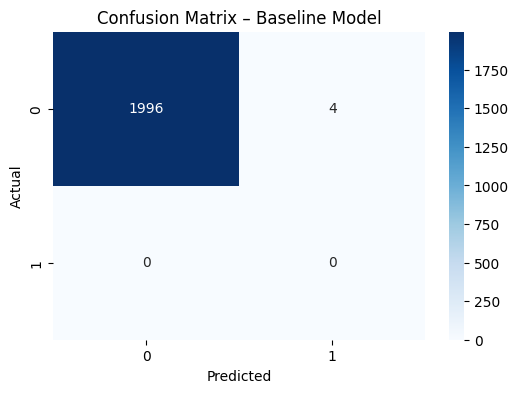

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

if 'y_pred' not in globals():
    y_pred = baseline_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Baseline Model")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       0.00      0.00      0.00         0

    accuracy                           1.00      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       1.00      1.00      1.00      2000



/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


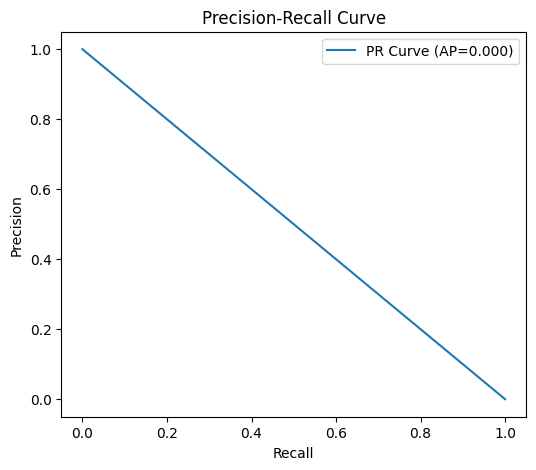

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_scores = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
ap_score = average_precision_score(y_test, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AP={ap_score:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

if 'pipeline' not in globals():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42))
    ])
    pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

if 'y_scores' not in globals():
    if 'pipeline' in globals():
        y_scores = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_scores = baseline_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_scores))
print("PR-AUC:", average_precision_score(y_test, y_scores))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       0.00      0.00      0.00         0

    accuracy                           1.00      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC: nan
PR-AUC: 0.0


/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ihamdan/L

In [ ]:
from sklearn.metrics import average_precision_score
ap_score = average_precision_score(y_test, y_scores)
print("Average Precision (PR-AUC):", ap_score)


Average Precision (PR-AUC): 0.0


/Users/ihamdan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


### Baseline Model Summary

This baseline model establishes a reference performance level for the project.
While overall accuracy may appear high due to class imbalance, recall provides a
more meaningful measure of performance. Future iterations will focus on improving
recall while managing false positives through alternative models and optimization
techniques.
